### Importing Necessary Packages

In [1]:
import random
import glob
import time
import pandas as pd
import numpy as np
import re
import xml.etree.ElementTree as ET
from sentence_transformers import SentenceTransformer
from rouge_score import rouge_scorer
from statistics import mean
from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
data_directory='./data/scisummnet_release1.1__20190413/top1000_complete'
embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')
data = {}

### Extracting Research Paper Data From XML files

In [3]:
# Function to extract abstract from XML tree
def extract_abstract(element):
    abstract = ''
    if element.tag == 'ABSTRACT':
        for child in element:
            line = child.text 
            # Text preprocessing
            line = line.lower()
            line = line.replace("quot", "")
            line = re.sub(r'https?://\S+', '', line) 
            line = re.sub(r'[^\w\s]', '', line)
            # Append to abstract
            abstract = abstract + '\n' + line
    
    return abstract

In [4]:
# Function to extract paper text from XML tree
def extract_data(element):
    text_data = (element.text or "").strip()
    # Separate abstract text from rest of the paper
    if element.tag != 'ABSTRACT':
        # Text preprocessing
        text_data = text_data.lower()
        text_data = text_data.replace("quot", "")
        text_data = re.sub(r'https?://\S+', '', text_data) 
        text_data = re.sub(r'[^\w\s]', '', text_data)

        for child in element:
            text_data = np.append(text_data, extract_data(child))  

    return text_data

In [5]:
# Function to extract all data related to a paper from dataset
def get_contents(document_path):
    summary_path = glob.glob(document_path + '/summary/*.txt')[0]
    article_path = glob.glob(document_path + '/Documents_xml/*.xml')[0]
    
    summary_file = open(summary_path)
    summary_content = summary_file.read()

    article_tree = ET.parse(article_path)
    article_root = article_tree.getroot()

    abstract_element = None

    for child in article_root:
        if child.tag == 'ABSTRACT':
            abstract_element = child

    sentences = extract_data(article_root)

    sentences = [s for s in list(sentences) if s != '']

    title = sentences[0]

    sentences = sentences[1:]

    sentence_embeddings = embedder.encode(sentences)

    if abstract_element: 
        abstract = extract_abstract(abstract_element)
        abstract = title + abstract 
    else:
        abstract = []

    contents = {'title': title, 'sentences': sentences, 'embeddings': sentence_embeddings, 'summary': summary_content, 'abstract': abstract}

    document_name = document_path.split('/')[-1]

    data[document_name] = contents
    
    return contents

# 1. Clustering-based Summarizer

### Elbow Method To Choose Optimum K-value 

In [6]:
def find_optimum_clusters(contents):
    
    np.random.seed(60)
    
    ks = range(2, 6)
    inertia = []
    for k in ks:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k, n_init='auto')
        # Fit model to embeddings
        model.fit(contents['embeddings'])
        # Append the inertia to the list of inertias
        inertia.append(model.inertia_)
        
    kn = KneeLocator(x=ks, y=inertia, curve='convex', direction='decreasing', S=0)
    optimal_num_clusters = kn.elbow

    # Plot ks vs inertias
    plt.plot(ks, inertia, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    
    #plt.show()
    plt.close()
    
    return optimal_num_clusters

### Fit Clustering Model on Data

In [7]:
def kMeansClustering(contents, num_clusters):
    
    np.random.seed(60)

    # Use the K-means clustering algorithm to create clusters of sentences that are grouped by similarity
    clustering_model = KMeans(n_clusters=num_clusters, n_init='auto')
    clustering_model.fit(contents['embeddings'])
    cluster_assignment = clustering_model.labels_
    cluster_center = clustering_model.cluster_centers_
    
    return cluster_assignment

### Generate Text Summary

In [8]:
# Function to generate the text summary by picking the first sentence in each cluster
def generate_summary(cluster_assignment, num_clusters):
    clustered_sentences = [[] for i in range(num_clusters)]
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        clustered_sentences[cluster_id].append(contents['sentences'][sentence_id])
    most_important_sentence = ""
    generated_summary = ""
    for i, cluster in enumerate(clustered_sentences):
        most_important_sentence = cluster[0][:1].upper() + cluster[0][1:]
        generated_summary += most_important_sentence + ". "
        
    return generated_summary

### Evaluate Generated Summary

In [9]:
# Function to evaluate the model performance
def evaluate(ls_documents, reference_summaries, generated_summaries):
    # Use Rouge score technique to evaluate text summary
    rouge_scoring = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

    score_dict = {   "document":[]
                   , "r1-precision":[]
                   , "r1-recall":[]
                   , "r1-f1-score":[]
                   , "r2-precision":[]
                   , "r2-recall":[]
                   , "r2-f1-score":[]
                   , "rL-precision":[]
                   , "rL-recall":[]
                   , "rL-f1-score":[]
                    }

    for i, (reference_summary, summary) in enumerate(zip(reference_summaries, generated_summaries)):
        score_dict['document'].append(ls_documents[i].split('/')[-1])
        if len(reference_summary) == 0:
            score_dict["r1-precision"].append(0)
            score_dict["r1-recall"].append(0)
            score_dict["r1-f1-score"].append(0)
            score_dict["r2-precision"].append(0)
            score_dict["r2-recall"].append(0)
            score_dict["r2-f1-score"].append(0)
            score_dict["rL-precision"].append(0)
            score_dict["rL-recall"].append(0)
            score_dict["rL-f1-score"].append(0)
        else:
            scores = rouge_scoring.score(reference_summary, summary)

            score_dict["r1-precision"].append(scores['rouge1'].precision)
            score_dict["r1-recall"].append(scores['rouge1'].recall)
            score_dict["r1-f1-score"].append(scores['rouge1'].fmeasure)
            score_dict["r2-precision"].append(scores['rouge2'].precision)
            score_dict["r2-recall"].append(scores['rouge2'].recall)
            score_dict["r2-f1-score"].append(scores['rouge2'].fmeasure)
            score_dict["rL-precision"].append(scores['rougeL'].precision)
            score_dict["rL-recall"].append(scores['rougeL'].recall)
            score_dict["rL-f1-score"].append(scores['rougeL'].fmeasure)
    
    return score_dict

### Iterate Over Entire Dataset

In [10]:
# Create lists to receive outputs
abstracts = []
manual_summaries = []
generated_summaries = []

In [11]:
# Iterate over papers in the dataset to generate sumamries
ls_documents = glob.glob(data_directory + '/*')

failed_documents = []

for i, doc in enumerate(ls_documents):
    try:
        start_time = time.time()
        contents = get_contents(doc)
        optimal_num_clusters = find_optimum_clusters(contents)
        cluster_assignment = kMeansClustering(contents, optimal_num_clusters)
        result = generate_summary(cluster_assignment, optimal_num_clusters)
        abstracts.append(contents['abstract'])
        manual_summaries.append(contents['summary'])
        generated_summaries.append(result)
        end_time = time.time()
        print(i+1, doc, len(contents['sentences']), 'Duration:', end_time - start_time)
    except:
        failed_documents.append(doc)
        print(i+1, doc, "FAILED")
        continue

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/sindhuswaroop/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


1 ./data/scisummnet_release1.1__20190413/top1000_complete/P99-1008 123 Duration: 5.434630870819092
2 ./data/scisummnet_release1.1__20190413/top1000_complete/J93-2003 677 Duration: 19.074784994125366
3 ./data/scisummnet_release1.1__20190413/top1000_complete/W08-0336 184 Duration: 6.193663835525513
4 ./data/scisummnet_release1.1__20190413/top1000_complete/N10-1119 157 Duration: 5.387308835983276
5 ./data/scisummnet_release1.1__20190413/top1000_complete/P04-3022 77 Duration: 2.133057117462158
6 ./data/scisummnet_release1.1__20190413/top1000_complete/J06-3003 600 Duration: 16.0647189617157
7 ./data/scisummnet_release1.1__20190413/top1000_complete/W08-0309 244 Duration: 6.792175769805908
8 ./data/scisummnet_release1.1__20190413/top1000_complete/P08-1114 145 Duration: 5.702299118041992
9 ./data/scisummnet_release1.1__20190413/top1000_complete/P87-1033 139 Duration: 5.215888023376465
10 ./data/scisummnet_release1.1__20190413/top1000_complete/J98-1006 338 Duration: 10.155189037322998
11 ./data

### Evaluate Model Performance

In [12]:
# Evaluate model performance
rouge_scores_manual_summaries = evaluate(ls_documents, manual_summaries, generated_summaries)
rouge_scores_abstracts = evaluate(ls_documents, abstracts, generated_summaries)

# Display scores
print('Average Scores against Manual Summaries:')
print('ROUGE-1 Precision:', mean([value for value in rouge_scores_manual_summaries['r1-precision'] if value !=0]))
print('ROUGE-1 Recall:', mean([value for value in rouge_scores_manual_summaries['r1-recall'] if value !=0]))
print('ROUGE-1 F1-Score:', mean([value for value in rouge_scores_manual_summaries['r1-f1-score'] if value !=0]))
print('ROUGE-2 Precision:', mean([value for value in rouge_scores_manual_summaries['r2-precision'] if value !=0]))
print('ROUGE-2 Recall:', mean([value for value in rouge_scores_manual_summaries['r2-recall'] if value !=0]))
print('ROUGE-2 F1-Score:', mean([value for value in rouge_scores_manual_summaries['r2-f1-score'] if value !=0]))
print('ROUGE-L Precision:', mean([value for value in rouge_scores_manual_summaries['rL-precision'] if value !=0]))
print('ROUGE-L Recall:', mean([value for value in rouge_scores_manual_summaries['rL-recall'] if value !=0]))
print('ROUGE-L F1-Score:', mean([value for value in rouge_scores_manual_summaries['rL-f1-score'] if value !=0]))

print('-------------------------------------')

print('Average Scores against Abstracts:')
print('ROUGE-1 Precision:', mean([value for value in rouge_scores_abstracts['r1-precision'] if value !=0]))
print('ROUGE-1 Recall:', mean([value for value in rouge_scores_abstracts['r1-recall'] if value !=0]))
print('ROUGE-1 F1-Score:', mean([value for value in rouge_scores_abstracts['r1-f1-score'] if value !=0]))
print('ROUGE-2 Precision:', mean([value for value in rouge_scores_abstracts['r2-precision'] if value !=0]))
print('ROUGE-2 Recall:', mean([value for value in rouge_scores_abstracts['r2-recall'] if value !=0]))
print('ROUGE-2 F1-Score:', mean([value for value in rouge_scores_abstracts['r2-f1-score'] if value !=0]))
print('ROUGE-L Precision:', mean([value for value in rouge_scores_abstracts['rL-precision'] if value !=0]))
print('ROUGE-L Recall:', mean([value for value in rouge_scores_abstracts['rL-recall'] if value !=0]))
print('ROUGE-L F1-Score:', mean([value for value in rouge_scores_abstracts['rL-f1-score'] if value !=0]))

Average Scores against Manual Summaries:
ROUGE-1 Precision: 0.4416460923667549
ROUGE-1 Recall: 0.22723446906688147
ROUGE-1 F1-Score: 0.28139273286507444
ROUGE-2 Precision: 0.18823371097255756
ROUGE-2 Recall: 0.08740460552386983
ROUGE-2 F1-Score: 0.11140678800843717
ROUGE-L Precision: 0.27412087250488004
ROUGE-L Recall: 0.13761208646827888
ROUGE-L F1-Score: 0.17095057208606912
-------------------------------------
Average Scores against Abstracts:
ROUGE-1 Precision: 0.4023910770331683
ROUGE-1 Recall: 0.259233680811292
ROUGE-1 F1-Score: 0.28924262901547854
ROUGE-2 Precision: 0.17236487807770523
ROUGE-2 Recall: 0.09597556365294062
ROUGE-2 F1-Score: 0.11197522576893867
ROUGE-L Precision: 0.24885647112844428
ROUGE-L Recall: 0.15474836417991147
ROUGE-L F1-Score: 0.17371066307344316


* Rouge-1 F1-score of 0.28 indicates 28% of unigram overlap between the reference summary and generated summary
* Rouge-2 F1-score of 0.11 indicates 11% of bigram overlap between the reference summary and generated summary
* Rouge-L F1-score of 0.17 indicates 17% overlap of longest common word-sequence between the reference summary and generated summary

In [13]:
# Save scores

df1 = pd.DataFrame(rouge_scores_manual_summaries)
df1.to_csv('./rouge_scores_manual_summaries.csv')

df2 = pd.DataFrame(rouge_scores_abstracts)
df2.to_csv('./rouge_scores_abstracts.csv')

### Visualize K-means clusters in 2-D

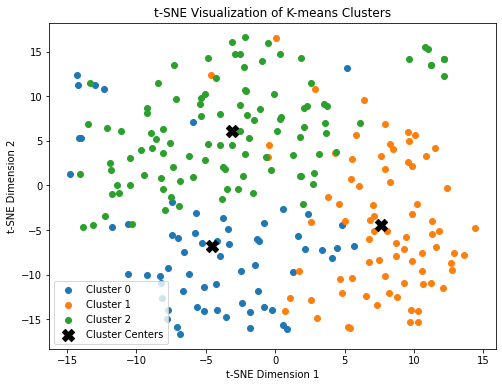

In [14]:
# Create a t-SNE object with 2 components (2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# clusterCenterFit the t-SNE on your data (corpus_embeddings)
embeddings_2d = tsne.fit_transform(contents['embeddings'])
cluster_centers_2d = np.zeros((optimal_num_clusters, 2))

# Plot the data points with different colors based on their cluster assignments
plt.figure(figsize=(8, 6))
for i in range(optimal_num_clusters):
    plt.scatter(embeddings_2d[cluster_assignment == i, 0],
                embeddings_2d[cluster_assignment == i, 1],
                label=f"Cluster {i}")
    cluster_centers_2d[i] = np.mean(embeddings_2d[cluster_assignment == i], axis=0)

# Plot the cluster centers with black 'X' markers
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1],
            marker='X', s=150, color='black', label='Cluster Centers')

plt.legend()
plt.title("t-SNE Visualization of K-means Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()